In [131]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import glob2 as glob
import missingno as msno
import plotly.express as px


In [8]:
relative_path = "data/raw/*.csv" 
file_list = glob.glob(relative_path)

dataframes = []


if not file_list:
    print("No CSV files found in the specified path.")
else:
    # Loop through the file list and read each CSV file into a df
    for file in file_list:
        try:
            df = pd.read_csv(file)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

In [27]:
#check this every time - idk why the order changes 
#name the dfs
df_event_results = dataframes[0]
df_country = dataframes[2]
df_games = dataframes[1]
df_results = dataframes[5]
df_athletes = dataframes[4]
df_medals = dataframes[3]

In [159]:
#check missing values
def check_missing_values(df):
    return df.isnull().sum()


check_missing_values(df_event_results)
check_missing_values(df_country)
check_missing_values(df_games)
check_missing_values(df_athletes)
check_missing_values(df_medals)
check_missing_values(df_results)



In [ ]:
df_games[df_games['end_date'].isna()]

#missing values for end_Date, start_date if the games were not held,
#isHeld is NA if the games took place which. These missing values will not affect our analysis

In [29]:
df_medals.head()

,edition,edition_id,year,country,country_noc,gold,silver,bronze,total
0,1896 Summer Olympics,1,1896,United States,USA,11,7,2,20
1,1896 Summer Olympics,1,1896,Greece,GRE,10,18,19,47
2,1896 Summer Olympics,1,1896,Germany,GER,6,5,2,13
3,1896 Summer Olympics,1,1896,France,FRA,5,4,2,11
4,1896 Summer Olympics,1,1896,Great Britain,GBR,2,3,2,7


In [224]:
df_medals_agg = df_medals.groupby('country')[['gold', 'silver', 'bronze', 'total']].sum()
df_medals_agg.describe()

,gold,silver,bronze,total
count,154.000000,154.000000,154.000000,154.000000
mean,43.837662,43.668831,46.590909,134.097403
std,121.137176,105.514430,100.827272,325.596482
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,3.000000
50%,3.000000,4.500000,6.000000,13.000000
75%,26.750000,33.500000,36.000000,98.500000
max,1194.000000,970.000000,845.000000,3009.000000


In [59]:
#historically, who won the most medals?? 

df_medals2 = df_medals.groupby('country_noc')[['total','gold', 'silver', 'bronze']].sum()
df_medals2.reset_index(inplace=True)


top5_rows = df_medals2.nlargest(5, 'total')

top5_countries = top5_rows['country_noc'].tolist()
top5_medals = top5_rows['total'].tolist()

print(f"The top 3 countries are: {top5_countries}")
print(f"The corresponding counts are: {top5_medals}")

The top 3 countries are: ['USA', 'URS', 'GER', 'GBR', 'FRA']
The corresponding counts are: [3009, 1204, 1098, 989, 950]


In [70]:
# Melt the DataFrame to long format 
top_50 = df_medals2.nlargest(50, 'total')
df_medals3 = top_50.drop(['total'], axis=1)
df_medals_melted = pd.melt(df_medals3, id_vars='country_noc', var_name='Medal', value_name='Count')

df_medals_melted.head()

,country_noc,Medal,Count
0,USA,gold,1194
1,URS,gold,473
2,GER,gold,355
3,GBR,gold,312
4,FRA,gold,287


/var/folders/07/8ng8f7q11l10nz1xwnk4zwv00000gn/T/ipykernel_47636/1994670736.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a futu

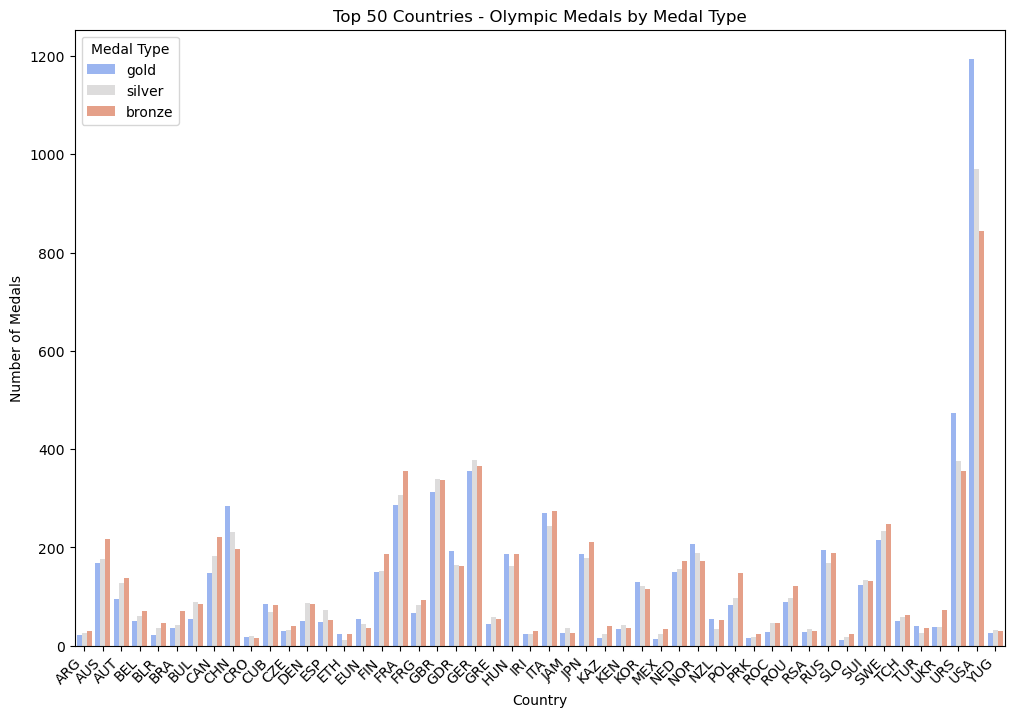

In [92]:
plt.figure(figsize=(12, 8))
sns.barplot(x='country_noc', y='Count', hue='Medal', data=df_top_50, palette='coolwarm', ci=None)
plt.title('Top 50 Countries - Olympic Medals by Medal Type')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.legend(title='Medal Type')
plt.xticks(rotation=45, ha='right')
plt.show()

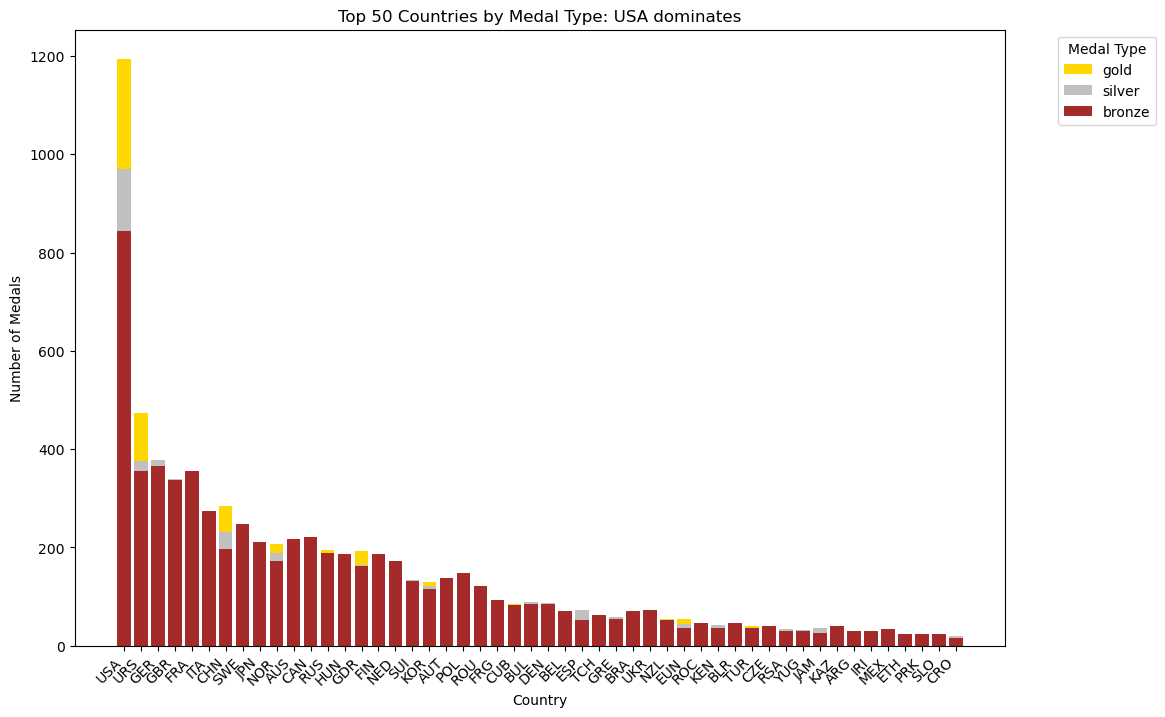

In [125]:
#chart should be stacked instead

#df_stacked = df_medals_melted.pivot_table(index='country_noc', columns='Medal', values='Count', fill_value=0)

df_stacked_sorted = df_stacked.sum(axis=1).sort_values(ascending=False).index
df_stacked = df_stacked.loc[df_stacked_sorted]


colors = {'gold': 'gold', 'silver': 'silver', 'bronze': 'brown'}

plt.figure(figsize=(12, 8))
for medal_type, color in colors.items():
    plt.bar(df_stacked.index, df_stacked[medal_type], color=color, label=medal_type)

plt.title('Top 50 Countries by Medal Type: USA dominates')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.legend(title='Medal Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [113]:
#has anything changed in the past 20 years?

#filter df to include 2004 Athens games onwards

df_last20 = df_medals[['year', 'country', 'total']].copy()

df_last20 = df_last20.loc[df_last20['year'] >= 1992]
df_last20.head()

,year,country,total
694,1992,Unified Team,112
695,1992,United States,108
696,1992,Germany,82
697,1992,People's Republic of China,54
698,1992,Cuba,31


In [123]:
total_by_country = df_last20.groupby('country')['total'].sum()
top_10_countries = total_by_country.sort_values(ascending=False).head(12)
top_10_countries_list = total_by_country.sort_values(ascending=False).head(12).index.tolist()

recent_games  = df_last20[df_last20['country'].isin(top_10_countries_list)]

recent_games.head()

,year,country,total
695,1992,United States,108
696,1992,Germany,82
697,1992,People's Republic of China,54
700,1992,Republic of Korea,29
702,1992,France,29


/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype

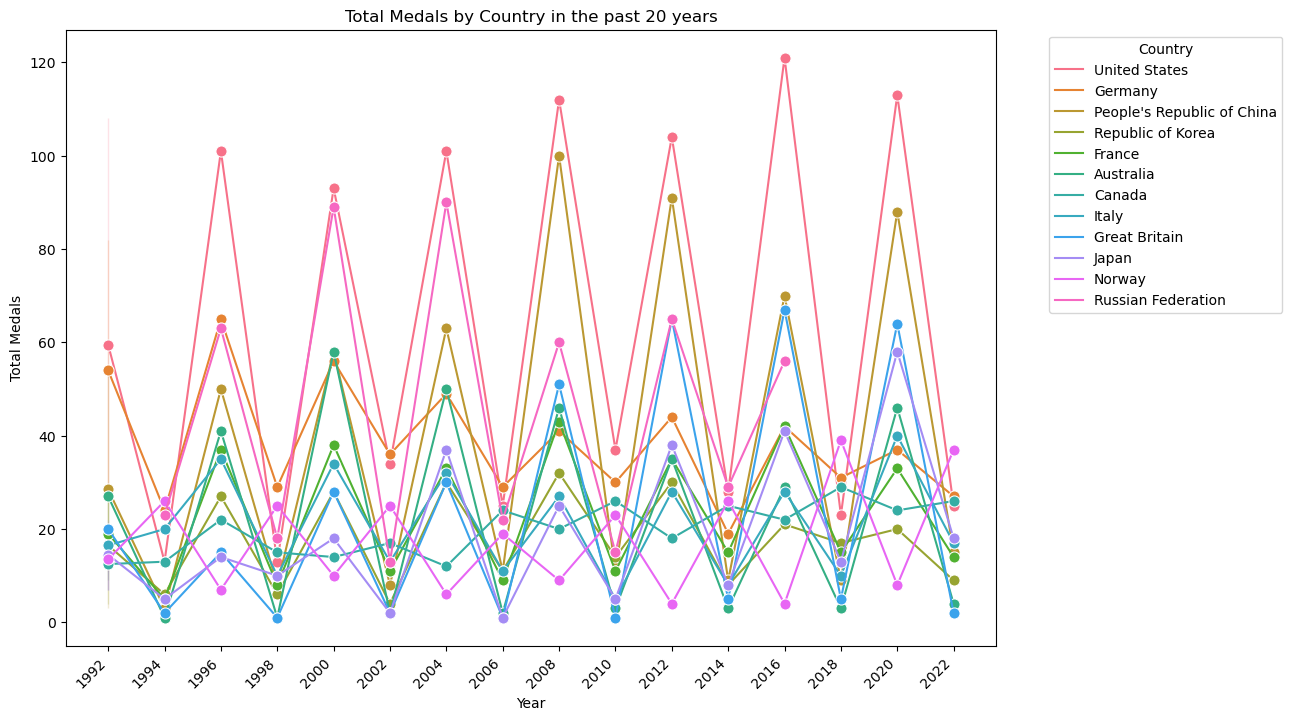

In [124]:

plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='total', hue='country', data=recent_games, marker='o', markersize=8)

plt.xticks(recent_games['year'].unique())

plt.title('Total Medals by Country in the past 20 years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.xticks(rotation=45, ha='right')  
plt.show()

In [193]:
#import gdp and population
df_gdp = pd.read_csv('data/raw/country_gdp.csv')
df_gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.276188e+09,3.395794e+09,2.610039e+09,3.126019e+09,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,...,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,...,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.330000e+11,1.370000e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.024137e+10,6.568544e+10,1.070000e+11


In [194]:
df_gdp.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)

In [200]:
df_country2 = pd.merge(df_country, df_gdp, how='left', left_on='country', right_on='Country Name')
df_country2.head(3)

,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
2,ALG,Algeria,Algeria,DZA,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11


In [201]:
exclude_columns = ['country_noc', 'country', 'Country Code', 'Country Name']
df_country2.loc[:, df_country2.columns.difference(exclude_columns)] /= 1e9 # convert to billions 
df_country2.head()

,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,0.537778,0.548889,0.546667,0.751111,0.800000,1.006667,...,20.564485,20.550583,19.998144,18.019554,18.896353,18.418860,18.904502,20.143452,14.583135,NaN
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,...,12.776225,13.228148,11.386853,11.861200,13.019726,15.156424,15.401826,15.162734,17.930565,18.882096
2,ALG,Algeria,Algeria,DZA,2.723615,2.434747,2.001445,2.702982,2.909316,3.136284,...,210.000000,214.000000,166.000000,160.000000,170.000000,175.000000,172.000000,146.000000,163.000000,192.000000
3,ASA,American Samoa,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.638000,0.643000,0.673000,0.671000,0.612000,0.639000,0.647000,0.716000,0.709000,NaN
4,AND,Andorra,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,...,3.193513,3.271686,2.789881,2.896610,3.000162,3.218420,3.155149,2.891001,3.325145,3.352033


In [202]:
df_country2['mean_gdp_last_10yr_bn'] = df_country2.iloc[:, -10:].mean(axis=1)
df_country2.head()

,country_noc,country,Country Name,Country Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,mean_gdp_last_10yr_bn
0,AFG,Afghanistan,Afghanistan,AFG,0.537778,0.548889,0.546667,0.751111,0.800000,1.006667,...,20.550583,19.998144,18.019554,18.896353,18.418860,18.904502,20.143452,14.583135,NaN,18.897674
1,ALB,Albania,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,...,13.228148,11.386853,11.861200,13.019726,15.156424,15.401826,15.162734,17.930565,18.882096,14.480580
2,ALG,Algeria,Algeria,DZA,2.723615,2.434747,2.001445,2.702982,2.909316,3.136284,...,214.000000,166.000000,160.000000,170.000000,175.000000,172.000000,146.000000,163.000000,192.000000,176.800000
3,ASA,American Samoa,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,...,0.643000,0.673000,0.671000,0.612000,0.639000,0.647000,0.716000,0.709000,NaN,0.660889
4,AND,Andorra,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,...,3.271686,2.789881,2.896610,3.000162,3.218420,3.155149,2.891001,3.325145,3.352033,3.109360


In [203]:
df_country_gdp = df_country2[['country_noc', 'country', 'Country Code', 'mean_gdp_last_10yr_bn']].copy()
df_country_gdp.to_clipboard(index=False)

In [176]:
missing_values_gdp = df_country_gdp['mean_gdp_last_10yr_bn'].isnull().sum()
missing_values_gdp

64

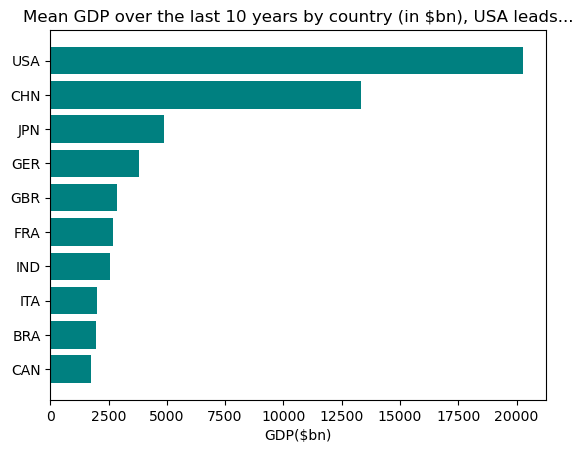

In [246]:
df_sorted = df_country_gdp.sort_values(by='mean_gdp_last_10yr_bn', ascending=False)
top_10_values = df_sorted.head(10)

plt.barh(top_10_values['country_noc'], top_10_values['mean_gdp_last_10yr_bn'], color='teal')
plt.xlabel('GDP($bn)')
plt.title('Mean GDP over the last 10 years by country (in $bn), USA leads...')
plt.gca().invert_yaxis()
plt.show()

In [240]:
df_pop = pd.read_csv('data/raw/country_population.csv')
df_pop.drop(['Country Name',  'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop.head()

,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,...,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0
1,Africa Eastern and Southern,AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,...,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720839314.0
2,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,...,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
3,Africa Western and Central,AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,...,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0
4,Angola,AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,...,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0


In [241]:
#df_pop.drop(['Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_pop2 = pd.merge(df_country, df_pop, how='left', left_on='country', right_on='Country_Updated')
df_pop2.head(3)

,country_noc,country,Country_Updated,Country Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,Afghanistan,AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
1,ALB,Albania,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837849.0,2811666.0,2775634.0
2,ALG,Algeria,Algeria,DZA,11394307.0,11598608.0,11778260.0,11969451.0,12179099.0,12381256.0,...,38000626.0,38760168.0,39543154.0,40339329.0,41136546.0,41927007.0,42705368.0,43451666.0,44177969.0,44903225.0


In [242]:
exclude_columns = ['country_noc', 'country', 'Country Code', 'Country_Updated']
df_pop2.loc[:, df_pop2.columns.difference(exclude_columns)] /= 1e6 # convert to millions 

In [243]:
#following a similar approach of taking the 10 year mean
df_pop2['mean_pop_last_10yr_mm'] = df_pop2.iloc[:, -10:].mean(axis=1)
df_country_pop = df_pop2[['country_noc', 'country', 'Country Code', 'mean_pop_last_10yr_mm']].copy()
df_country_pop.to_clipboard(index=False)

In [245]:
missing_values_pop = df_country_pop['mean_pop_last_10yr_mm'].isnull().sum()
missing_values_pop

51

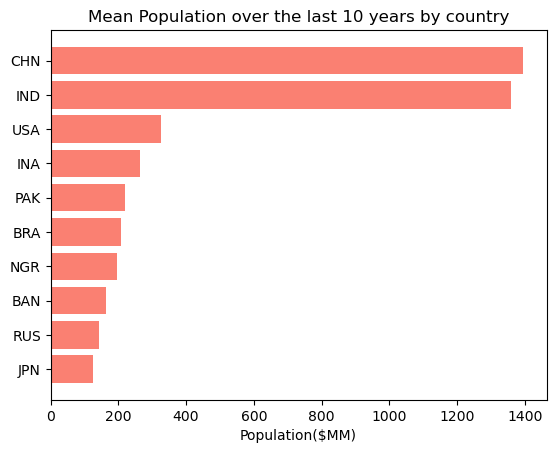

In [258]:
df_sorted_pop = df_country_pop.sort_values(by='mean_pop_last_10yr_mm', ascending=False)
top_10_values_pop = df_sorted_pop.head(10)


plt.barh(top_10_values_pop['country_noc'], top_10_values_pop['mean_pop_last_10yr_mm'], color='salmon')
plt.xlabel('Population($MM)')
plt.title('Mean Population over the last 10 years by country')
plt.gca().invert_yaxis()
plt.show()

In [305]:
#group by total medals for each country

df_grouped = df_medals.groupby('country_noc')['total'].sum()
df_grouped = pd.DataFrame(df_grouped)
df_grouped.reset_index(inplace=True)

In [306]:
#check correlation between variables and medals tally

df_merged = pd.merge(df_grouped, df_country_gdp[['country_noc','mean_gdp_last_10yr_bn']
                                                                        ],how='left', on='country_noc')

df_merged2 = pd.merge(df_merged, df_country_pop[['country_noc','mean_pop_last_10yr_mm']
                                                                        ],how='left', on='country_noc')


df_merged2.head()


,country_noc,total,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm
0,AFG,2,18.897674,36.294729
1,AHO,1,NaN,NaN
2,ALG,17,176.800000,41.494506
3,ANZ,12,NaN,NaN
4,ARG,77,535.400000,44.249313


/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



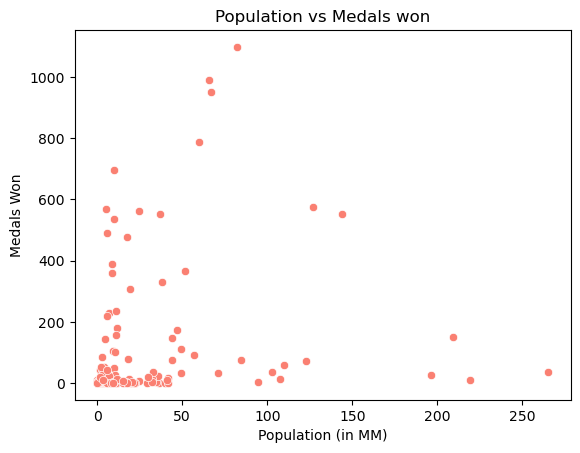

In [316]:
excluded_countries = ['CHN', 'IND', 'USA']
df_filtered = df_merged2[~df_merged2['country_noc'].isin(excluded_countries)]
sns.scatterplot(y='total', x='mean_pop_last_10yr_mm', data=df_filtered, color='salmon')

# Add labels and title
plt.xlabel('Population (in MM)')
plt.ylabel('Medals Won')
plt.title('Population vs Medals won')

# Show the plot
plt.show()

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



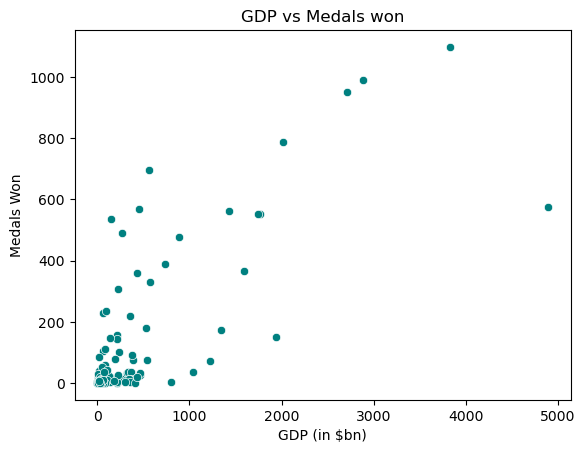

In [318]:
sns.scatterplot(y='total', x='mean_gdp_last_10yr_bn', data=df_filtered, color='teal')

# Add labels and title
plt.xlabel('GDP (in $bn)')
plt.ylabel('Medals Won')
plt.title('GDP vs Medals won')

# Show the plot
plt.show()

In [321]:
#contingent size
df_athletes.head()

,athlete_id,name,sex,born,height,weight,country,country_noc,description,special_notes
0,16809,Károly Teppert,Male,1891-07-20,na,na,Hungary,HUN,Károly Teppert started competing in cycling in...,na
1,43737,Andrzej Socharski,Male,1947-08-31,173.0,72,Poland,POL,na,Listed in Olympians Who Won a Medal at the Wor...
2,50147,Nathalie Wunderlich,Female,1971-06-03,170.0,50,Switzerland,SUI,na,na
3,5085,Miha Lokar,Male,1935-09-10,182.0,76,Yugoslavia,YUG,na,Listed in Olympians Who Won a Medal at the Eur...
4,136329,Austin Hack,Male,1992-05-17,203.0,100,United States,USA,na,na


In [330]:
df_contingent = df_athletes.groupby('country_noc')['athlete_id'].count()
df_contingent = pd.DataFrame(df_contingent)
df_contingent.rename({'athlete_id': 'total_athletes'}, axis=1, inplace=True)

In [331]:
df_merged3 = pd.merge(df_merged2, df_contingent, on='country_noc')
df_merged3.head()

,country_noc,total,mean_gdp_last_10yr_bn,mean_pop_last_10yr_mm,total_athletes
0,AFG,2,18.897674,36.294729,120
1,AHO,1,NaN,NaN,59
2,ALG,17,176.800000,41.494506,413
3,ANZ,12,NaN,NaN,71
4,ARG,77,535.400000,44.249313,2085


/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/Anahata/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



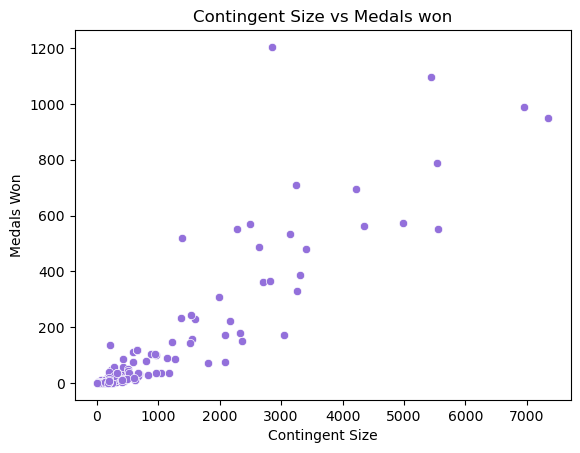

In [338]:
excluded_countries = ['USA']
df_filtered = df_merged3[~df_merged3['country_noc'].isin(excluded_countries)]

sns.scatterplot(y='total', x='total_athletes', data=df_filtered, color='mediumpurple')

# Add labels and title
plt.xlabel('Contingent Size')
plt.ylabel('Medals Won')
plt.title('Contingent Size vs Medals won')

# Show the plot
plt.show()

In [340]:
df_results

,result_id,event_title,edition,edition_id,sport,sport_url,result_location,result_participants,result_format,result_detail,result_description,start_date,end_date,time
0,9270,"7 metres, 1907 Rating, Open",1920 Summer Olympics,7,Sailing,/editions/7/sports/SAL,Oostende,8 from 2 countries,"Three races, with final places decided by tota...",na,There were two yachts competing. Britain’s An...,1920-07-07,1920-07-09,na
1,29722,"Featherweight (≤60 kilograms), Men",1980 Summer Olympics,20,Weightlifting,/editions/20/sports/WLF,"Dvorets sporta Izmaylovo, Moskva",18 from 14 countries,Total of best lifts in snatch and clean & jerk...,na,The favorite was likely Soviet Viktor Mazin wh...,1980-07-22,na,14:00-19:00
2,54126,"Platform, Men",1948 Summer Olympics,12,Diving,/editions/12/sports/DIV,"Wembley Arena, Wembley, London",25 from 15 countries,10 metre platform. Final round only. Four comp...,na,"Sammy Lee won this event, leading in both the ...",1948-08-04,1948-08-05,na
3,4684,"100 metres Backstroke, Men",1920 Summer Olympics,7,Swimming,/editions/7/sports/SWM,"Zwemstadion van Antwerpen, Antwerpen",12 from 6 countries,na,na,Watten Paoa Kealoha set a world record of 1:14...,1920-08-22,1920-08-23,na
4,1465,"Slalom, Men",2002 Winter Olympics,47,Alpine Skiing,/editions/47/sports/ALP,"Park City Mountain Resort, Park City, Utah (Kn...",77 from 43 countries,"Two runs, total time determined placement.",Jesse Hunt,The last few World Cups had gone to Austrian B...,2002-02-23,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7324,6049,"400 metres Freestyle, Women",1968 Summer Olympics,17,Swimming,/editions/17/sports/SWM,"Alberca Olímpica Francisco Márquez, Ciudad de ...",30 from 17 countries,na,na,At the US Olympic Trials Debbie Meyer had set ...,1968-10-19,1968-10-20,na
7325,84835,"Sabre, Team, Men",1936 Summer Olympics,11,Fencing,/editions/11/sports/FEN,"Sportforum, Turnhalle, Reichssportfeld, Berlin...",107 from 21 countries,na,na,On the middle of an era of total domination of...,1936-08-12,1936-08-13,na
7326,356742,"Sprint, Men",2016 Summer Olympics,59,Cycling Track,/editions/59/sports/CTR,"Velódromo Olímpico do Rio, Parque Olímpico da ...",27 from 16 countries,"Qualifying over 3½ laps, or 875 metres. Match ...",na,Jason Kenny of Great Britain had won the Olymp...,2016-08-12,2016-08-14,na
7327,8424,"100 metres Breaststroke, Men",2000 Summer Olympics,25,Swimming,/editions/25/sports/SWM,"Sydney International Aquatic Centre, Olympic P...",66 from 60 countries,na,na,In June and July 2000 Roman Sludnov of Russia ...,2000-09-16,2000-09-17,na
